<a href="https://colab.research.google.com/github/Mabus00/Jupyter-Notebook/blob/main/Petals_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.11.0
Running on TPU  ['10.40.183.210:8470']


In [2]:
import re, os, glob
import numpy as np
from matplotlib import pyplot as plt
from google.cloud import storage

# Download data from Kaggle

### Before doing this go to Kaggle and get an API; under the corner icon select "Account", scroll down to API, select "Create new API", and save it somewhere you can access. 

In [4]:
! pip install -q kaggle

In [28]:
# need this to upload files
from google.colab import files

In [ ]:
# upload the kaggle.json file you just created
files.upload()

In [33]:
# You need to create that directory - the API does not do it for you. You place the token there. 
! mkdir -p ~/.kaggle

In [34]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [35]:
# set permission to read, write, execute
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


### Get the dataset name from the Kaggle competition page; either at bottom of page or in data section.

In [12]:
! kaggle competitions download -c tpu-getting-started

100% 4.79G/4.79G [00:44<00:00, 165MB/s]
100% 4.79G/4.79G [00:44<00:00, 116MB/s]


In [ ]:
!unzip tpu-getting-started.zip -d petals_data

### Create GCS bucket(with default setup) 
### Go to Google Cloud Storage, Settings and at the bottom generate a new key; the key is linked to your project. I used a YouTube video and followed the directions "google cloud storage credentials"

In [16]:
# imports all the necessary libraries for google cloud storage
!pip install --upgrade google-cloud-storage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install --upgrade google-auth google-auth-oauthlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.11.2 requires google-auth-oauthlib<0.5,>=0.4.1, but you have google-auth-oauthlib 1.0.0 which is incompatible.


In [ ]:
# upload the kaggle.json file you just created
files.upload()

In [37]:
! cp fresh-tape-381213-60c98f39030b.json ~/.kaggle/

In [38]:
# set permission to read, write, execute
! chmod 600 ~/.kaggle/fresh-tape-381213-60c98f39030b.json

In [21]:
# provide new key generated above
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "fresh-tape-381213-60c98f39030b.json"

In [6]:
storage_client = storage.Client()

In [3]:
# create a new bucket; need to run this every time
bucket_name = "fresh_petals_metal"

In [42]:
# only needed when creating a bucket
bucket = storage_client.create_bucket(bucket_name)

Conflict: ignored

In [43]:
bucket = storage_client.get_bucket(bucket_name)

In [44]:
print('Bucket {} created.'.format(bucket.name))

Bucket fresh_petals_metal created.


In [45]:
bucket.location

'US'

In [46]:
# print bucket details
vars(bucket)

{'name': 'fresh_petals_metal',
 '_properties': {'kind': 'storage#bucket',
  'selfLink': 'https://www.googleapis.com/storage/v1/b/fresh_petals_metal',
  'id': 'fresh_petals_metal',
  'name': 'fresh_petals_metal',
  'projectNumber': '735712066390',
  'metageneration': '1',
  'location': 'US',
  'storageClass': 'STANDARD',
  'etag': 'CAE=',
  'timeCreated': '2023-03-20T18:38:37.494Z',
  'updated': '2023-03-20T18:38:37.494Z',
  'iamConfiguration': {'bucketPolicyOnly': {'enabled': False},
   'uniformBucketLevelAccess': {'enabled': False},
   'publicAccessPrevention': 'inherited'},
  'locationType': 'multi-region',
  'rpo': 'DEFAULT'},
 '_changes': set(),
 '_client': <google.cloud.storage.client.Client at 0x7f5967acb490>,
 '_acl': <google.cloud.storage.acl.BucketACL at 0x7f5967aaffd0>,
 '_default_object_acl': <google.cloud.storage.acl.DefaultObjectACL at 0x7f5967aaf8b0>,
 '_label_removals': set(),
 '_user_project': None}

In [60]:
# use this for individual files
def upload_to_bucket(blob_name, file_path, bucket_name):
  try:
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.upload_from_file_name(file_path)
    return True
  except Exception as e:
    print(e)
    return False

In [106]:
# use this to upload entire folders
def upload_from_directory(directory_path, dest_bucket_name):
    rel_paths = glob.glob(directory_path + '/**', recursive=True)
    bucket = storage_client.get_bucket(dest_bucket_name)
    for local_file in rel_paths:
        remote_path = f'{"/".join(local_file.split(os.sep)[3:])}'
        if os.path.isfile(local_file):
            blob = bucket.blob(remote_path)
            blob.upload_from_filename(local_file)

### Upload files from Colab to Cloud Storage bucket

In [3]:
# Import necessary libraries
from google.colab import auth

# Authenticate the notebook with Google Cloud
auth.authenticate_user()

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [331, 331]

batch_size = 16 * tpu_strategy.num_replicas_in_sync

gcs_pattern = 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec'
validation_split = 0.19
filenames = tf.io.gfile.glob(gcs_pattern)
split = len(filenames) - int(len(filenames) * validation_split)
train_fns = filenames[:split]
validation_fns = filenames[split:]
        
def parse_tfrecord(example):
  features = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    "one_hot_class": tf.io.VarLenFeature(tf.float32),
  }
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_jpeg(example['image'], channels=3)
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [*IMAGE_SIZE, 3])
  one_hot_class = tf.reshape(tf.sparse.to_dense(example['one_hot_class']), [5])
  return image_tensor, one_hot_class

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

def get_training_dataset():
  dataset = load_dataset(train_fns)

  # Create some additional training images by randomly flipping and
  # increasing/decreasing the saturation of images in the training set. 
  def data_augment(image, one_hot_class):
    modified = tf.image.random_flip_left_right(image)
    modified = tf.image.random_saturation(modified, 0, 2)
    return modified, one_hot_class
  augmented = dataset.map(data_augment, num_parallel_calls=AUTO)

  # Prefetch the next batch while training (autotune prefetch buffer size).
  return augmented.repeat().shuffle(2048).batch(batch_size).prefetch(AUTO) 

training_dataset = get_training_dataset()
validation_dataset = load_dataset(validation_fns).batch(batch_size).prefetch(AUTO)

In [8]:
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [4]:
def display_one_flower(image, title, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  plt.title(title, fontsize=16, color=color)
  
# If model is provided, use it to generate predictions.
def display_nine_flowers(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(13,13))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_flower(images[i], titles[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

training_viz_iterator = get_dataset_iterator(training_dataset, 9)

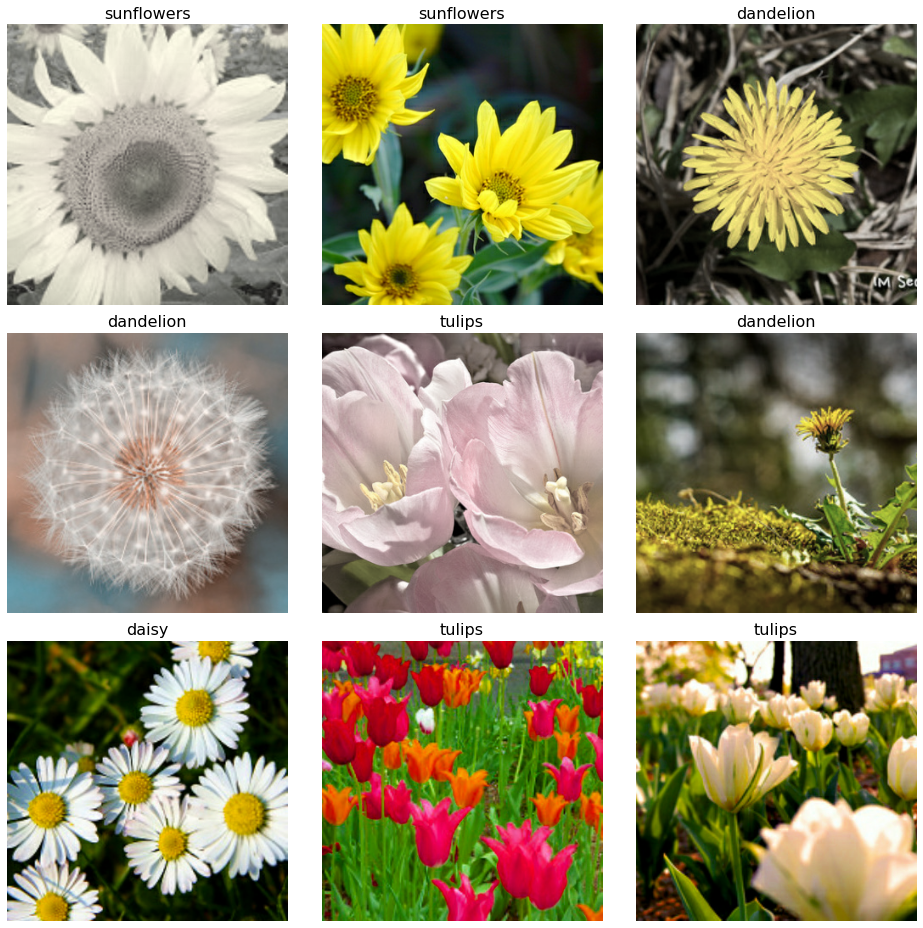

In [10]:
# Re-run this cell to show a new batch of images
images, classes = next(training_viz_iterator)
class_idxs = np.argmax(classes, axis=-1) # transform from one-hot array to class number
labels = [CLASSES[idx] for idx in class_idxs]
display_nine_flowers(images, labels)